In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/DevinDeSilva/kinetics-i3d-Pytorch.git --branch master --single-branch
! pip install -q scikit-video
! pip install -q ffmpeg-python
! mv /content/kinetics-i3d-Pytorch/model /content/
! mv /content/kinetics-i3d-Pytorch/video_utils.py /content/video_utils.py

Cloning into 'kinetics-i3d-Pytorch'...
remote: Enumerating objects: 794, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 794 (delta 12), reused 0 (delta 0), pack-reused 772
Receiving objects: 100% (794/794), 446.72 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Updating files: 100% (58/58), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.4 MB/s eta 0:00:00


In [3]:
! pip install -q neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 8.1 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 221 (delta 108), reused 197 (delta 91), pack-reused 0
Receiving objects: 100% (221/221), 64

---

In [4]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [5]:
import os
import json
import numbers
import csv
import h5py
import skvideo
import skvideo.io 
import cv2
import gc

from glob import glob
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import pickle
from collections import defaultdict, OrderedDict
import neptune
import ffmpeg
import random

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
import torchvision
from torchvision import datasets, transforms

from model.I3D_Pytorch import I3D
from video_utils import *

from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-5-9ab89a9cb9c4>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:

from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [7]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 1024, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 1024,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 20,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,  
    "I3D":{
        "checkpoint":'kinetics-i3d-Pytorch/data/pytorch_checkpoints/rgb_imagenet.pkl',
        "VID_LOC":"/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2/Videos",
        "batch_size":8
    }
}

if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [9]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [10]:
data_dict = dataReader.generate(unseen_classes=[1,3], seen_ratio=0.2, unseen_ratio=0.8, window_size=12, window_overlap=10, resample_freq=50)

In [11]:
gc.collect()
torch.cuda.empty_cache()

In [12]:
import cv2 
from glob import glob, iglob

In [13]:
video_path = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2/Videos/'

In [14]:
def read_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 224)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 224)

    frames = []

    i = 0
    while True and (i < 60):
        ret, frame = cap.read()

        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
        i+=1

    cap.release()
    frames = torch.Tensor(np.transpose(np.array(frames), (2,0,1))).to(torch.int8)
    return frames

In [15]:
video_data = defaultdict(list)

for c in dataReader.idToLabel:
    # Process the file here
    j = 0
    action_name = c
    search_path = video_path+'/'+c+'/*'
    for fpath in iglob(search_path, recursive=False):
      if j < 8:
        video_data[action_name].append(read_video_frames(fpath))
        j += 1
      else:
        break

ValueError: ignored

In [ ]:
for k in video_data.keys():
  video_data[k] = torch.stack(video_data[k])

In [ ]:
video_data.keys()

In [ ]:
[i[1] for i in dataReader.label_map]

In [ ]:
np.unique(data_dict['train']['y'])

In [ ]:
for k in video_data.keys():
  print(k, len(video_data[k]))

In [ ]:
a1 = video_data['Nordic walking'][0]
a2 = video_data['Nordic walking'][1]
a3 = video_data['Nordic walking'][2]
a4 = video_data['Nordic walking'][3]
a1.shape

In [ ]:
b1 = torch.Tensor(np.transpose(a1[:85, ...], (3, 0, 1, 2)))
b2 = torch.Tensor(np.transpose(a2[:85, ...], (3, 0, 1, 2)))
b3 = torch.Tensor(np.transpose(a3[:85, ...], (3, 0, 1, 2)))
b4 = torch.Tensor(np.transpose(a4[:85, ...], (3, 0, 1, 2)))

In [ ]:
bs = torch.stack([b1,b2,b3,b4])
bs.shape

In [ ]:
vid_enc = I3D(input_channel=3)
vid_enc.load_state_dict(torch.load(config["I3D"]["checkpoint"]))

for param in vid_enc.features.parameters():
    param.requires_grad = False

for param in vid_enc.features[16:].parameters():
    param.requires_grad = True

In [ ]:
bs_output = vid_enc(bs.float())

In [ ]:
bs_output[0].shape

In [ ]:
bs_output[0].mean(axis=0).shape

In [ ]:
all_classes = dataReader.idToLabel

In [ ]:
all_videos = []
for c in all_classes:
  all_videos.append(video_data[c])

In [ ]:
torch_videos = torch.cat(all_videos)
torch_videos.shape

In [ ]:
gpu_model = vid_enc.to(device)
gpu_data = torch.transpose(torch_videos.float(), 2,0,1).to(device)

In [ ]:
bs_output = vid_enc(torch.transpose(torch_videos.float(), 2,0,1))
bs_output[0].shape

In [ ]:
def semantic_space_generation_step(model, action_list):

  

  with tqdm(dataloader, unit="batch", desc="sematic space generation") as tepoch:
        features = []
        cls = []
        for batch in tepoch:
          X,label = batch
          X = X.to(torch.float32).to(device)
          feat = model(X)
          if mode == 400:
            feat = feat[1]
          elif mode == 1024:
            feat = feat[2]
          else:
            raise NotImplementedError()
          features.append(feat)
          cls.append(label)

        features = torch.concat(features,dim=0).cpu().detach().numpy()
        cls = torch.concat(cls,dim=0).numpy()


        mean_feat = []
        mean_cls = []
        mean_clsname = []
        for sel_cls in np.unique(cls):
          mean_feat.append(features[cls==sel_cls].mean(axis=0))
          mean_cls.append(sel_cls)
          mean_clsname.append(dataset.id2cls[sel_cls])

        cls = np.asarray(mean_cls)
        clsname = np.asarray(mean_clsname)
        features = np.asarray(mean_feat)
        return clsname, features

In [ ]:
all_classes = dataReader.idToLabel


In [ ]:
seen_classes = data_dict['seen_classes']
seen_classes_names = [all_classes[i] for i in data_dict['seen_classes']]
train_dt = CompositDataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], video_dict=video_data, action_classes=seen_classes, action_names=seen_classes_names, seq_len=100)
train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)

NameError: ignored

In [ ]:
for dt in train_dl:
  x,y,t,v = dt 
  break

video_class :  vacuum cleaning
video_class :  vacuum cleaning
video_class :  ironing
video_class :  vacuum cleaning
video_class :  ironing
video_class :  lying
video_class :  watching TV
video_class :  house cleaning
video_class :  computer work
video_class :  descending stairs
video_class :  lying
video_class :  computer work
video_class :  computer work
video_class :  computer work
video_class :  descending stairs
video_class :  computer work
video_class :  computer work
video_class :  Nordic walking
video_class :  lying
video_class :  ironing
video_class :  computer work
video_class :  Nordic walking
video_class :  computer work
video_class :  cycling
video_class :  house cleaning
video_class :  cycling
video_class :  cycling
video_class :  vacuum cleaning
video_class :  car driving
video_class :  standing
video_class :  watching TV
video_class :  standing


In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        return x, y,target

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class CompositDataset(Dataset):
    def __init__(self, data, actions, video_dict, action_classes, action_names, seq_len=120, neigh=3):
        super(CompositDataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.video_dict = video_dict
        self.seq_len = seq_len
        self.action_classes = action_classes
        self.neigh = neigh
        # build action to id mapping dict
        self.n_action = len(self.actions)
        # self.Id2action = dict(zip(action_classes, action_names))
        self.action2Id = dict(zip(action_classes, range(self.n_action)))
        # self.action2Times = {i: len(v) for i,v in video_dict.items()}
        # print(self.action2Times, self.action2Id, self.Id2action)

    def __getVideo(self, video_class):
      print("video_class : ", video_class)
      lst = list(range(self.action2Times[video_class]))
      rand_idx = random.sample(lst, self.neigh)
      rand_videos = [torch.Tensor(np.transpose(self.video_dict[video_class][i][:70, ...], (3, 0, 1, 2))) for i in rand_idx]
      torch_videos = torch.stack(rand_videos)
      return torch_videos

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_videos = self.__getVideo(self.Id2action[target])
        return x, y, target, y_videos

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.sigmoid(out)
        # out = self.fcLayer2(out)
        return out

class CombinedModel(nn.Module):
  def __init__(self, imu_encoder, video_encoder, mode=400):
        super(CombinedModel, self).__init__()
        self.imu_encoder = imu_encoder
        self.video_encoder = video_encoder
        self.mode = mode
  
  def forward(self, x_imu):
    x_imu = self.imu_encoder(x_imu)
    return x_imu
    

In [ ]:
def create_model(config,in_ft,seq_len,seen_classes):
  # build model
  vid_enc = I3D(input_channel=3)
  vid_enc.load_state_dict(torch.load(config["I3D"]["checkpoint"]))

  for param in vid_enc.features.parameters():
      param.requires_grad = False

  for param in vid_enc.features[16:].parameters():
      param.requires_grad = True

  imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
  imu_enc = IMUEncoder(**imu_config)

  model = CombinedModel(imu_enc,vid_enc)

  return model

---

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def newLoss(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    return output

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

def shuffledTripletLoss(pred_feat, anchor_feat, y, bs=32, loss_fn=nn.TripletMarginLoss(margin=0.1, p=2, reduction='none')):
    neg_feat = torch.concat([anchor_feat[bs//2:, ...], anchor_feat[:bs//2, ...]], dim=0)
    pos_feat = anchor_feat

    neg_y = torch.concat([y[bs//2:], y[:bs//2]])
    y_mask = (y!=neg_y).long()

    output_arr = loss_fn(pred_feat, pos_feat, neg_feat)
    masked_arr = torch.multiply(output_arr, y_mask)

    output = masked_arr.mean()
    return output

In [ ]:
def semantic_space_generation_step(model, dataloader, dataset, mode=400):
  with tqdm(dataloader, unit="batch", desc="sematic space generation") as tepoch:
        features = []
        cls = []
        for batch in tepoch:
          X,label = batch
          X = X.to(torch.float32).to(device)
          feat = model(X)
          if mode == 400:
            feat = feat[1]
          elif mode == 1024:
            feat = feat[2]
          else:
            raise NotImplementedError()
          features.append(feat)
          cls.append(label)

        features = torch.concat(features,dim=0).cpu().detach().numpy()
        cls = torch.concat(cls,dim=0).numpy()


        mean_feat = []
        mean_cls = []
        mean_clsname = []
        for sel_cls in np.unique(cls):
          mean_feat.append(features[cls==sel_cls].mean(axis=0))
          mean_cls.append(sel_cls)
          mean_clsname.append(dataset.id2cls[sel_cls])

        cls = np.asarray(mean_cls)
        clsname = np.asarray(mean_clsname)
        features = np.asarray(mean_feat)
        return clsname, features

In [ ]:
def train_step(model, dataloader, dataset, sem_space,optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = sem_space[dataset.action_classes,...]

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, orig_cls_id = batch
            X = X.float().to(device)
            
            target_feat = sem_space[orig_cls_id, ...]
            target_feat = target_feat.float()
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader, dataset, sem_space, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = sem_space[dataset.action_classes,...]
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, orig_cls_id = batch
            X = X.float().to(device)
            
            target_feat = sem_space[orig_cls_id,...]
            target_feat = target_feat.float()
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4, figsize=(15, 15))
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [ ]:
# run = neptune.init_run(
#     project="FYP-Group22/ICANN-Logs",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
# )  # your credentials

<ipython-input-22-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-89


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
semantic_class

<ipython-input-27-ab0eec90cdfc>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  semantic_class[actionList]


IndexError: ignored

Generate Video Data ...


<ipython-input-24-bda20e1721ad>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'datetime.date'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['parameters'] = config


Loading Vids -> memory:   0%|          | 0/177 [00:00<?, ?it/s]

/content/video_utils.py:65: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(pic.transpose([3,0,1,2]))


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.832



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.883



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.919



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.914



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.941



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.946



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.953



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.952



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.954



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.896



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.945



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.946



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.952



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.943



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.958



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.954



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.938



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.961



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.953



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.960



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

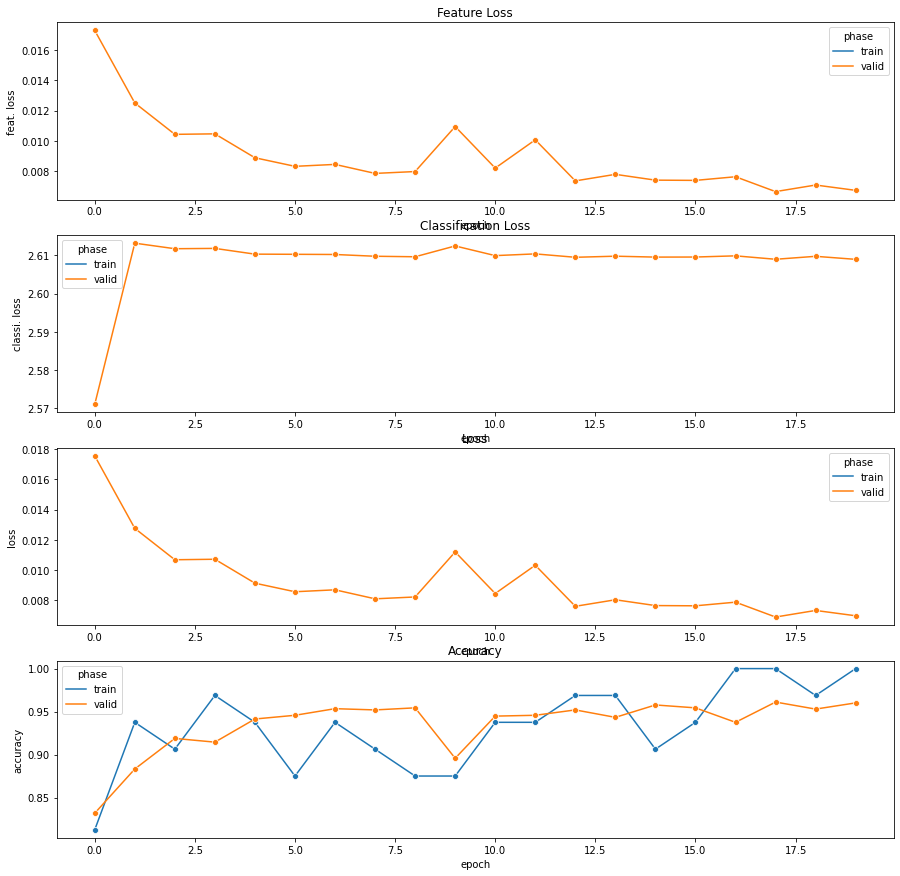

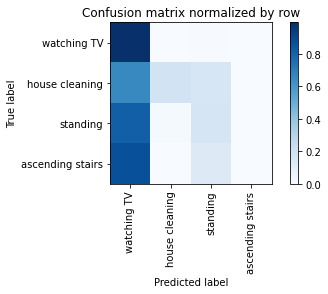

Overall accuracy: 0.265

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.419      0.171      0.243      0.331       1851|	 watching TV: 0.816,	house cleaning: 0.013,	
  house cleaning       0.934      0.185      0.309      0.328       1839|	 watching TV: 0.654,	standing: 0.161,	
ascending stairs       0.000      0.000      0.000      0.193       1079|	 watching TV: 0.872,	standing: 0.128,	
     watching TV       0.185      0.995      0.311      0.148        831|	 standing: 0.005,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.473      0.265      0.228        1.0       5600|	      

{'accuracy': 0.2648214285714286, 'precision': 0.38441997961108887, 'recall': 0.3376970353553758, 'f1': 0.21564805916832613, 'samples': 5600, 'loss': 310.1982169151306, 'feat. loss': 309.42705512046814, 'classi. loss': 7711.6204261779785

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.831



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.878



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.926



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.935



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.931



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.918



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.938



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.931



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.942



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.945



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.931



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.956



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.943



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.943



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.959



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.943



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.938



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

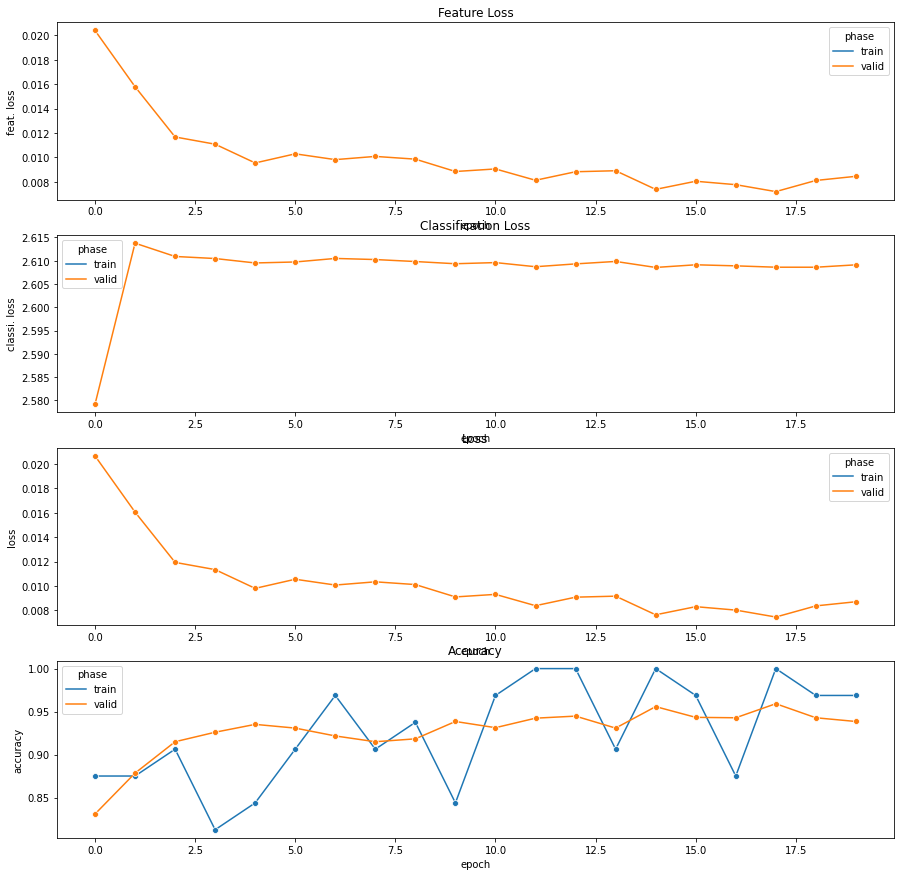

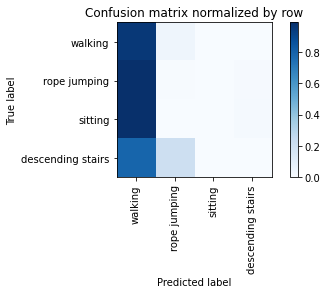

Overall accuracy: 0.403

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.429      0.955      0.592      0.422       2334|	 rope jumping: 0.045,	descending stairs: 0.000,	
          sitting       0.000      0.000      0.000      0.324       1796|	 walking: 0.987,	descending stairs: 0.013,	rope jumping: 0.001,	
descending stairs       0.034      0.001      0.002      0.171        948|	 walking: 0.785,	rope jumping: 0.211,	sitting: 0.003,	
     rope jumping       0.007      0.004      0.005      0.083        458|	 walking: 0.985,	descending stairs: 0.011,	

----------------------------------------------------------------------------------------------------
      avg / total       0.187      0.403      0.250        1.0       5536|	      

{'accuracy': 0.40335982658959535, 'precision': 0.11752278112738859, 'recall': 0.2402157417581884, 'f1': 0.14987366747939596, 'samples': 5536, 'loss': 346.334489941597, 'feat. loss': 34

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.770



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.881



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.931



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.929



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.939



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.938



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.938



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.937



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

KeyboardInterrupt: ignored

In [ ]:
# run['parameters'] = config
fold_metric_scores = []

print("Generate Video Data ...")
# video_transforms = transforms.Compose([CenterCrop(224)])
# video_data = CollectedDataset(config["I3D"]["VID_LOC"],video_transforms,device)
# video_dl = torch.utils.data.DataLoader(video_data, batch_size=config["I3D"]["batch_size"], shuffle=True, num_workers=1, pin_memory=True)

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = create_model(config, in_ft, seq_len, seen_classes)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        #Generate Sementic spaces
        semantic_class,semantic_space = semantic_space_generation_step(model.video_encoder,video_dl,video_data, mode=config['feat_size'])
        
        # re-arrange semantic space
        activity_dict = dict(zip(semantic_class,semantic_space))
        semantic_space = np.array([activity_dict[c] for c in actionList])
        semantic_space = torch.from_numpy(semantic_space).to(device)

        train_metrics = train_step(model, train_dl, train_dt,semantic_space,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        # log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,semantic_space,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt,semantic_space,loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    # log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
# log('global', '',seen_score_df.mean().to_dict())
run.stop()
